In [0]:
import numpy as np
import torch
import torchvision.transforms as transfroms
import torchvision.transforms.functional as F
from torchvision.datasets import FashionMNIST
from torchvision.datasets import CIFAR10
import matplotlib.pyplot as plt
import torchvision.models as models
import torch.nn as nn
import torch.optim as optim


In [3]:
import torchvision.transforms as transforms
transfrom = transfroms.Compose([transforms.Resize(256),  # 1. Resize smallest side to 256.
                                transforms.RandomCrop(224), # 2. Crop random square of 224x224 pixels.
                                transforms.RandomHorizontalFlip(),
                                transforms.ToTensor(), # 3. Convert to pytorch tensor.
                                transforms.Normalize(mean = [0.485, 0.456, 0.406],  # normalize.
                                std = [0.229, 0.224, 0.225])])


train_set = CIFAR10(root="./data", train=True, transform=transfrom, download=True)
val_set = CIFAR10(root="./data", train=False, transform=transfrom, download=True)


print("This dataset has {0} training images".format(len(train_set)))

# img_index = 2
# img, label = train_set[img_index]
#img = F.to_tensor(img)
# print("Image size is {0}x{1}x{2}".format(img.shape[0], img.shape[1], img.shape[2]))

classes = ["airplane", "car", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]
# print('Image {0} is a {1}'.format(img_index, classes[label]))

# plt.figure()
# plt.imshow(img.transpose(0, 2).transpose(0, 1))
# plt.grid(False)
# plt.axis('off')
# plt.show()



Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
This dataset has 50000 training images


Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.6.0


Train-epoch 0. Iteration 00100 / 00500, Avg-Loss: 1.0810, Accuracy: 0.6179
Train-epoch 0. Iteration 00200 / 00500, Avg-Loss: 0.8793, Accuracy: 0.6901
Train-epoch 0. Iteration 00300 / 00500, Avg-Loss: 0.7872, Accuracy: 0.7228
Train-epoch 0. Iteration 00400 / 00500, Avg-Loss: 0.7320, Accuracy: 0.7436
Train-epoch 0. Iteration 00500 / 00500, Avg-Loss: 0.6938, Accuracy: 0.7571
Validation-epoch 0. Avg-Loss: 0.4462, Accuracy: 0.8458
Train-epoch 1. Iteration 00100 / 00500, Avg-Loss: 0.4508, Accuracy: 0.8429
Train-epoch 1. Iteration 00200 / 00500, Avg-Loss: 0.4480, Accuracy: 0.8445
Train-epoch 1. Iteration 00300 / 00500, Avg-Loss: 0.4536, Accuracy: 0.8425
Train-epoch 1. Iteration 00400 / 00500, Avg-Loss: 0.4527, Accuracy: 0.8425
Train-epoch 1. Iteration 00500 / 00500, Avg-Loss: 0.4451, Accuracy: 0.8459
Validation-epoch 1. Avg-Loss: 0.3829, Accuracy: 0.8703
Train-epoch 2. Iteration 00100 / 00500, Avg-Loss: 0.3784, Accuracy: 0.8682
Train-epoch 2. Iteration 00200 / 00500, Avg-Loss: 0.3721, Accurac

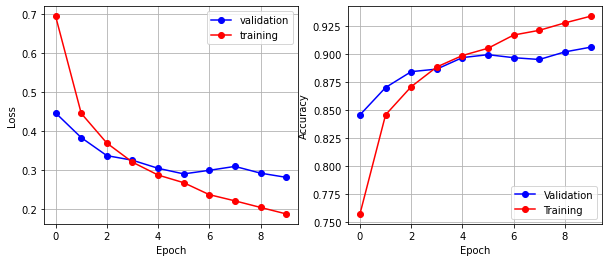

In [29]:
def train_model(model, loss_fn, batchSize, trainset, valset, optimizer, num_epochs):
  
  # Shuffling is needed in case dataset is not shuffled by default.
  train_loader = torch.utils.data.DataLoader(dataset = train_set,
                                              batch_size = batchSize,
                                              shuffle = True)
  # We don't need to bach the validation set but let's do it anyway.
  val_loader = torch.utils.data.DataLoader(dataset = val_set,
                                            batch_size = batchSize,
                                            shuffle = False) # No need.
  
  # Define number of epochs.
  N = num_epochs

  # log accuracies and losses.
  train_accuracies = []; val_accuracies = []
  train_losses = []; val_losses = []

  # GPU enabling.
  model = model.cuda()
  loss_fn = loss_fn.cuda()


  # Training loop. Please make sure you understand every single line of code below.
  # Go back to some of the previous steps in this lab if necessary.
  for epoch in range(0, N):
      correct = 0.0
      cum_loss = 0.0

      # Make a pass over the training data.
      model.train()
      for (i, (inputs, labels)) in enumerate(train_loader):
          inputs = inputs.cuda()
          labels = labels.cuda()

          # Forward pass. (Prediction stage)
          scores = model(inputs)
          #print("Scores: ",scores)
          #print("Labels: ", labels)
          loss = loss_fn(scores, labels)
          #print(loss)
        
          # Count how many correct in this batch.
          max_scores, max_labels = scores.max(1)
          correct += (max_labels == labels).sum().item()
          cum_loss += loss.item()
          #print("Cum_loss", cum_loss)

          # Zero the gradients in the network.
          optimizer.zero_grad()

          #Backward pass. (Gradient computation stage)
          loss.backward()

          # Parameter updates (SGD step) -- if done with torch.optim!
          optimizer.step()

          # Parameter updates (SGD step) -- if done manually!
          # for param in model.parameters():
          #   param.data.add_(-learningRate, param.grad)

          # Logging the current results on training.
          if (i + 1) % 100 == 0:
              print('Train-epoch %d. Iteration %05d / %05d, Avg-Loss: %.4f, Accuracy: %.4f' % 
                    (epoch, i + 1, len(train_loader), cum_loss / (i + 1), correct / ((i + 1) * batchSize)))

      train_accuracies.append(correct / len(trainset))
      train_losses.append(cum_loss / (i + 1))   

      # Make a pass over the validation data.
      correct = 0.0
      cum_loss = 0.0
      model.eval()
      for (i, (inputs, labels)) in enumerate(val_loader):
          inputs = inputs.cuda()
          labels = labels.cuda()

          # Forward pass. (Prediction stage)
          scores = model(inputs)
          cum_loss += loss_fn(scores, labels).item()

           # Count how many correct in this batch.
          max_scores, max_labels = scores.max(1)
          correct += (max_labels == labels).sum().item()

      val_accuracies.append(correct / len(valset))
      val_losses.append(cum_loss / (i + 1))

      # Logging the current results on validation.
      print('Validation-epoch %d. Avg-Loss: %.4f, Accuracy: %.4f' % 
            (epoch, cum_loss / (i + 1), correct / len(valset)))
      
  return train_accuracies, val_accuracies, train_losses, val_losses



val_losses=[]
train_losses=[]
val_accuracies=[]
train_accuracies=[]

batchSize = 100
model = torch.hub.load('pytorch/vision:v0.6.0', 'alexnet', pretrained=True)
model.classifier[6] = nn.Linear(4096,10)
loss_fn = nn.CrossEntropyLoss()
learningRate = 3e-3

optimizer = optim.SGD(model.parameters(), lr = learningRate, 
                      momentum = 0.9, weight_decay = 1e-4)

train_accuracies, val_accuracies, train_losses, val_losses = train_model(model, loss_fn, batchSize, train_set, val_set, optimizer, 10)


plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(val_losses, "bo-", label="val-loss")
plt.plot(train_losses, "ro-", label="train-loss")
plt.grid("on")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend(["validation", "training"], loc="upper right")

plt.subplot(1, 2, 2)
plt.plot(val_accuracies, "bo-", label="val-acc")
plt.plot(train_accuracies, "ro-", label="train-acc")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.grid("on")
plt.legend(["Validation", "Training"], loc="lower right")
plt.show()

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.6.0


Train-epoch 0. Iteration 00100 / 00500, Avg-Loss: 2.3019, Accuracy: 0.1090
Train-epoch 0. Iteration 00200 / 00500, Avg-Loss: 2.3007, Accuracy: 0.1084
Train-epoch 0. Iteration 00300 / 00500, Avg-Loss: 2.2885, Accuracy: 0.1137
Train-epoch 0. Iteration 00400 / 00500, Avg-Loss: 2.2514, Accuracy: 0.1411
Train-epoch 0. Iteration 00500 / 00500, Avg-Loss: 2.2112, Accuracy: 0.1631
Validation-epoch 0. Avg-Loss: 1.9674, Accuracy: 0.2747
Train-epoch 1. Iteration 00100 / 00500, Avg-Loss: 1.9661, Accuracy: 0.2670
Train-epoch 1. Iteration 00200 / 00500, Avg-Loss: 1.9248, Accuracy: 0.2788
Train-epoch 1. Iteration 00300 / 00500, Avg-Loss: 1.8779, Accuracy: 0.2976
Train-epoch 1. Iteration 00400 / 00500, Avg-Loss: 1.8404, Accuracy: 0.3135
Train-epoch 1. Iteration 00500 / 00500, Avg-Loss: 1.8037, Accuracy: 0.3285
Validation-epoch 1. Avg-Loss: 1.5594, Accuracy: 0.4257
Train-epoch 2. Iteration 00100 / 00500, Avg-Loss: 1.5899, Accuracy: 0.4141
Train-epoch 2. Iteration 00200 / 00500, Avg-Loss: 1.5588, Accurac

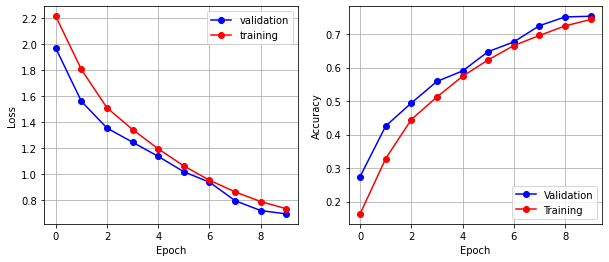

In [5]:
def train_model(model, loss_fn, batchSize, trainset, valset, optimizer, num_epochs):
  
  # Shuffling is needed in case dataset is not shuffled by default.
  train_loader = torch.utils.data.DataLoader(dataset = train_set,
                                              batch_size = batchSize,
                                              shuffle = True)
  # We don't need to bach the validation set but let's do it anyway.
  val_loader = torch.utils.data.DataLoader(dataset = val_set,
                                            batch_size = batchSize,
                                            shuffle = False) # No need.
  
  # Define number of epochs.
  N = num_epochs

  # log accuracies and losses.
  train_accuracies = []; val_accuracies = []
  train_losses = []; val_losses = []

  # GPU enabling.
  model = model.cuda()
  loss_fn = loss_fn.cuda()


  # Training loop. Please make sure you understand every single line of code below.
  # Go back to some of the previous steps in this lab if necessary.
  for epoch in range(0, N):
      correct = 0.0
      cum_loss = 0.0

      # Make a pass over the training data.
      model.train()
      for (i, (inputs, labels)) in enumerate(train_loader):
          inputs = inputs.cuda()
          labels = labels.cuda()

          # Forward pass. (Prediction stage)
          scores = model(inputs)
          #print("Scores: ",scores)
          #print("Labels: ", labels)
          loss = loss_fn(scores, labels)
          #print(loss)
        
          # Count how many correct in this batch.
          max_scores, max_labels = scores.max(1)
          correct += (max_labels == labels).sum().item()
          cum_loss += loss.item()
          #print("Cum_loss", cum_loss)

          # Zero the gradients in the network.
          optimizer.zero_grad()

          #Backward pass. (Gradient computation stage)
          loss.backward()

          # Parameter updates (SGD step) -- if done with torch.optim!
          optimizer.step()

          # Parameter updates (SGD step) -- if done manually!
          # for param in model.parameters():
          #   param.data.add_(-learningRate, param.grad)

          # Logging the current results on training.
          if (i + 1) % 100 == 0:
              print('Train-epoch %d. Iteration %05d / %05d, Avg-Loss: %.4f, Accuracy: %.4f' % 
                    (epoch, i + 1, len(train_loader), cum_loss / (i + 1), correct / ((i + 1) * batchSize)))

      train_accuracies.append(correct / len(trainset))
      train_losses.append(cum_loss / (i + 1))   

      # Make a pass over the validation data.
      correct = 0.0
      cum_loss = 0.0
      model.eval()
      for (i, (inputs, labels)) in enumerate(val_loader):
          inputs = inputs.cuda()
          labels = labels.cuda()

          # Forward pass. (Prediction stage)
          scores = model(inputs)
          cum_loss += loss_fn(scores, labels).item()

           # Count how many correct in this batch.
          max_scores, max_labels = scores.max(1)
          correct += (max_labels == labels).sum().item()

      val_accuracies.append(correct / len(valset))
      val_losses.append(cum_loss / (i + 1))

      # Logging the current results on validation.
      print('Validation-epoch %d. Avg-Loss: %.4f, Accuracy: %.4f' % 
            (epoch, cum_loss / (i + 1), correct / len(valset)))
      
  return train_accuracies, val_accuracies, train_losses, val_losses




val_losses=[]
train_losses=[]
val_accuracies=[]
train_accuracies=[]

batchSize = 100
model = torch.hub.load('pytorch/vision:v0.6.0', 'alexnet', pretrained=False)
model.classifier[6] = nn.Linear(4096,10)
loss_fn = nn.CrossEntropyLoss()
learningRate = 3e-3

optimizer = optim.SGD(model.parameters(), lr = learningRate, 
                      momentum = 0.9, weight_decay = 1e-4)

train_accuracies, val_accuracies, train_losses, val_losses = train_model(model, loss_fn, batchSize, train_set, val_set, optimizer, 10)


plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(val_losses, "bo-", label="val-loss")
plt.plot(train_losses, "ro-", label="train-loss")
plt.grid("on")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend(["validation", "training"], loc="upper right")

plt.subplot(1, 2, 2)
plt.plot(val_accuracies, "bo-", label="val-acc")
plt.plot(train_accuracies, "ro-", label="train-acc")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.grid("on")
plt.legend(["Validation", "Training"], loc="lower right")
plt.show()